# Тема: Look-alike

In [1]:
import numpy as np
import pandas as pd
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score, \
                            precision_recall_curve, confusion_matrix, log_loss
import catboost as cb

import warnings
warnings.simplefilter("ignore")

pd.options.display.max_columns = 30

In [2]:
def get_metrics(y_valid, preds, matrix=True):
    
    precision, recall, thresholds = precision_recall_curve(y_valid, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    roc_auc = round(roc_auc_score(y_valid, preds), 3)
    logloss = round(log_loss(y_valid, preds), 3)

    ix = np.argmax(fscore)
    if matrix == True:
        print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc-AUC=%.3f, log-loss=%.3F' % (
                        thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc, logloss))
    
        plt.figure(figsize=(8, 6))
        font = {'size' : 12}
        plt.rc('font', **font)

        cnf_matrix = confusion_matrix(y_valid, preds>thresholds[ix])
        plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'], title='Confusion matrix')
        plt.show()
    else:
        
        return thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc, logloss

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 1. взять любой набор данных для бинарной классификации.

In [32]:
df = pd.read_csv("data/6_web/data_banknote_authentication.txt", header=None)
df.rename(columns={4:'target'}, inplace=True)
df.head(3)

,0,1,2,3,target
0,3.6216,8.6661,-2.8073,-0.44699,0
1,4.5459,8.1674,-2.4586,-1.46210,0
2,3.8660,-2.6383,1.9242,0.10645,0


In [25]:
df['target'].value_counts()

0    762
1    610
Name: target, dtype: int64

### 3. сделать feature engineering

In [33]:
def transform_data(data):
    
    for i1, col1 in enumerate(set(df.columns) - set(['target'])):
        for i2, col2 in enumerate(set(df.columns) - set(['target'])):
            data['%s_%s_1' % (col1, col2)] = data[col1] - data[col2]
            data['%s_%s_2' % (col1, col2)] = data[col1] + data[col2]
            data['%s_%s_3' % (col1, col2)] = data[col1] * data[col2]

    return data

df = transform_data(df)

In [34]:
df.shape

(1372, 1025)

In [35]:
categorical_features = df.select_dtypes(include=(np.object)).columns.to_list()
X = df.drop('target', axis=1)
y = df['target']

### 4. обучить любой классификатор (какой вам нравится) и посчитать метрики качества (roc auc, pr/rec/f1, logloss)

In [36]:
X_train, X_valid = train_test_split(X, train_size=0.7, shuffle=True, random_state=5)
y_train, y_valid = train_test_split(y, train_size=0.7, shuffle=True, random_state=5)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((960, 1024), (960,), (412, 1024), (412,))

In [37]:
params = {
    "n_estimators": 300,
    "max_depth": 6,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
     "cat_features": categorical_features, 
    "early_stopping_rounds": 25,
    "random_state": 42}

model = cb.CatBoostClassifier(**params, verbose=30)

model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)])

Learning rate set to 0.052964
0:	test: 0.9988007	test1: 0.9968350	best: 0.9968350 (0)	total: 35.2ms	remaining: 10.5s
30:	test: 1.0000000	test1: 1.0000000	best: 1.0000000 (5)	total: 1.06s	remaining: 9.19s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 1
bestIteration = 5

Shrink model to first 6 iterations.


Best Threshold=0.651942, F-Score=1.000, Precision=1.000, Recall=1.000, Roc-AUC=1.000, log-loss=0.259
Confusion matrix, without normalization
[[222   0]
 [  1 189]]


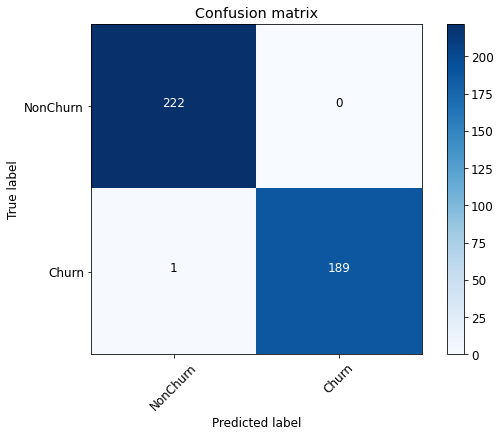

In [38]:
preds = model.predict_proba(X_valid)[:, 1:]

get_metrics(y_valid, preds, matrix=True)    

### 5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть

In [39]:
def separation(coef=0.25, detail=True):
    
    mod_data = df.copy()
    pos_ind = np.where(mod_data['target'].values == 1)[0]
    np.random.shuffle(pos_ind)
    pos_sample_len = int(np.ceil(coef * len(pos_ind)))
    
    if detail == True:
        print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
    pos_sample = pos_ind[:pos_sample_len]

    mod_data['class_test'] = -1
    mod_data.loc[pos_sample,'class_test'] = 1
    
    if detail == True:
        print('target variable:\n', mod_data.iloc[:,-1].value_counts())
        return mod_data
    
    else:
        val = mod_data.iloc[:,-1].value_counts()
        return mod_data, val

### 6. применить random negative sampling для построения классификатора в новых условиях

In [40]:
def rnc(mod_data, detail=True):
    
    mod_data = mod_data.sample(frac=1)
    neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
    sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
    pos_sample = mod_data[mod_data['class_test']==1]
    if detail == True:
        print(neg_sample.shape, pos_sample.shape)
    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)
    
    return sample_train, sample_test

### 7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)

In [41]:
def get_model(sample_train, sample_test, detail=True):
    
    X_train = sample_train.drop(['target', 'class_test'], axis=1)
    y_train = sample_train['target']
    X_valid = sample_test.drop(['target', 'class_test'], axis=1)
    y_valid = sample_test['target']
    
    model = cb.CatBoostClassifier(**params, silent=True)

    model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_valid, y_valid)])


    preds = model.predict_proba(X_valid)[:, 1:]
    
    if detail == True:
        get_metrics(y_valid, preds)
        
    else:
        thresholds, fscore, precision, recall, roc_auc, logloss = get_metrics(y_valid, preds, detail)
        return thresholds, fscore, precision, recall, roc_auc, logloss

Using 153/610 as positives and unlabeling the rest
target variable:
 -1    1219
 1     153
Name: class_test, dtype: int64
(153, 1026) (153, 1026)
Best Threshold=0.717234, F-Score=1.000, Precision=1.000, Recall=1.000, Roc-AUC=1.000, log-loss=0.173
Confusion matrix, without normalization
[[662   0]
 [  1 403]]


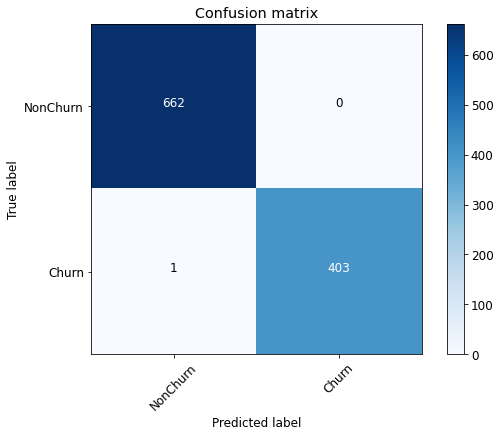

In [42]:
mod_data = separation()
sample_train, sample_test = rnc(mod_data)
get_model(sample_train, sample_test)

### 8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [43]:
stata_model = pd.DataFrame(columns=['class -1', 'class 1', 'sample_train', 'sample_test', 'Threshold', 'F-Score',
                                   'Precision', 'Recall', 'Roc-AUC', 'log-loss'])

for i in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    
    mod_data, val = separation(coef=i, detail=False)
    stata_model.loc[f'Доля P_{i}', 'class -1'] = val[-1]
    stata_model.loc[f'Доля P_{i}', 'class 1'] = val[1]

    sample_train, sample_test = rnc(mod_data, detail=False)
    stata_model.loc[f'Доля P_{i}', 'sample_train'] = sample_train.shape[0]
    stata_model.loc[f'Доля P_{i}', 'sample_test'] = sample_test.shape[0]

    thresholds, fscore, precision, recall, roc_auc, logloss = get_model(sample_train, sample_test, detail=False)
    stata_model.loc[f'Доля P_{i}', 'Threshold'] = thresholds
    stata_model.loc[f'Доля P_{i}', 'log-loss'] = logloss
    stata_model.loc[f'Доля P_{i}', 'F-Score'] = fscore
    stata_model.loc[f'Доля P_{i}', 'Precision'] = precision
    stata_model.loc[f'Доля P_{i}', 'Recall'] = recall
    stata_model.loc[f'Доля P_{i}', 'Roc-AUC'] = roc_auc
    
stata_model

,class -1,class 1,sample_train,sample_test,Threshold,F-Score,Precision,Recall,Roc-AUC,log-loss
Доля P_0.1,1311,61,122,1250,0.623202,0.989671,0.979554,1,0.999,0.21
Доля P_0.2,1250,122,244,1128,0.799641,0.989643,1,0.979499,1,0.205
Доля P_0.3,1189,183,366,1006,0.774953,1,1,1,1,0.13
Доля P_0.4,1128,244,488,884,0.607608,1,1,1,1,0.394
Доля P_0.5,1067,305,610,762,0.685893,1,1,1,1,0.144
Доля P_0.6,1006,366,732,640,0.845624,0.9967,1,0.993421,1,0.089
Доля P_0.7,945,427,854,518,0.620682,1,1,1,1,0.357
Доля P_0.8,884,488,976,396,0.65141,1,1,1,1,0.266
Доля P_0.9,823,549,1098,274,0.586215,1,1,1,1,0.421


<b>Бонусный вопрос:</b>

Как вы думаете, какой из методов на практике является более предпочтительным: random negative sampling или 2-step approach? 
- думаю, что более предпочтительный метод - это random negative sampling